In [1]:
import sys
sys.path.insert(0, r"..\..\molass-library")
from molass import get_version
assert get_version(toml_only=True) >= "0.8.0", "Molass version 0.8.0 or higher is required."
import numpy as np
import matplotlib.pyplot as plt

# Import monopore models for comparison
from molass.SEC.Models.GEC import robust_gec_monopore_pdf
from molass.SEC.Models.SdmMonoPore import sdm_monopore_pdf, sdm_monopore_gamma_pdf

# Import lognormal pore models
from molass.SEC.Models.LognormalPore import (
    gec_lognormal_pore_pdf,
    sdm_lognormal_pore_pdf,
    sdm_lognormal_pore_gamma_pdf
)

## Test Parameters

Setting up parameters for the models.

In [2]:
# Time grid
t = np.linspace(0.01, 300, 500)

# Pore interaction parameters
N = 1000.0      # Pore interaction scale
T = 0.5        # Residence time scale
me = 1.5       # Pore entry exponent
mp = 1.5       # Pore residence exponent

# Lognormal distribution parameters
mu = 4.25      # log-mean (exp(4.25) ≈ 70 Å)
sigma = 0.3    # log-std (moderate polydispersity)

# Size exclusion parameters
Rg = 30.0      # Molecule radius of gyration (Å)

# Mobile phase parameters (SDM)
N0 = 14400.0   # Plate number (48000*0.3 for 30cm column)
t0 = 5.0       # Hold-up time

# Gamma distribution parameter
k = 1.5        # Gamma shape (k=1 is exponential)

# PDF scaling
scale = 1.0
x0 = 0.0       # Time offset for GEC

poresize = np.exp(mu)
print("Parameters set:")
print(f"  Pore size: exp({mu}) = {poresize:.1f} Å (median)")
print(f"  Pore std:  σ = {sigma}")
print(f"  Molecule:  Rg = {Rg} Å")
print(f"  Plate #:   N0 = {N0}")

Parameters set:
  Pore size: exp(4.25) = 70.1 Å (median)
  Pore std:  σ = 0.3
  Molecule:  Rg = 30.0 Å
  Plate #:   N0 = 14400.0


## Test 1: GEC Lognormal vs Monopore

Compare lognormal pore distribution with equivalent monopore model.

Computing GEC models...


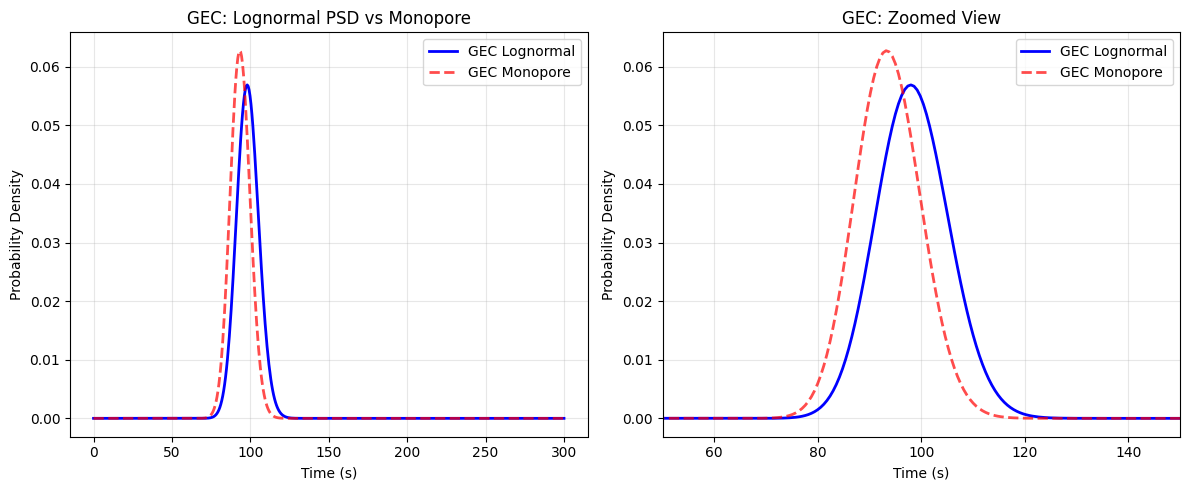

✓ GEC models computed and plotted


In [3]:
print("Computing GEC models...")

# Lognormal pore
pdf_gec_lognormal = gec_lognormal_pore_pdf(t, scale, N, T, me, mp, mu, sigma, Rg, x0)

# Monopore for comparison (using median pore size)
rho = min(Rg / poresize, 1)  # Exclusion fraction based on median pore size
np_mono = N * (1 - rho)**me  # Equivalent number of pore interactions
tp_mono = T * (1 - rho)**mp  # Equivalent residence time
pdf_gec_mono = robust_gec_monopore_pdf(t, np_mono, tp_mono)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, pdf_gec_lognormal, 'b-', linewidth=2, label='GEC Lognormal')
plt.plot(t, pdf_gec_mono, 'r--', linewidth=2, label='GEC Monopore', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Probability Density')
plt.title('GEC: Lognormal PSD vs Monopore')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(t, pdf_gec_lognormal, 'b-', linewidth=2, label='GEC Lognormal')
plt.plot(t, pdf_gec_mono, 'r--', linewidth=2, label='GEC Monopore', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Probability Density')
plt.title('GEC: Zoomed View')
plt.xlim(50, 150)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ GEC models computed and plotted")

## Test 2: SDM Lognormal with Mobile Phase Dispersion

Testing the SDM extension with Brownian dispersion term.

Computing SDM models...


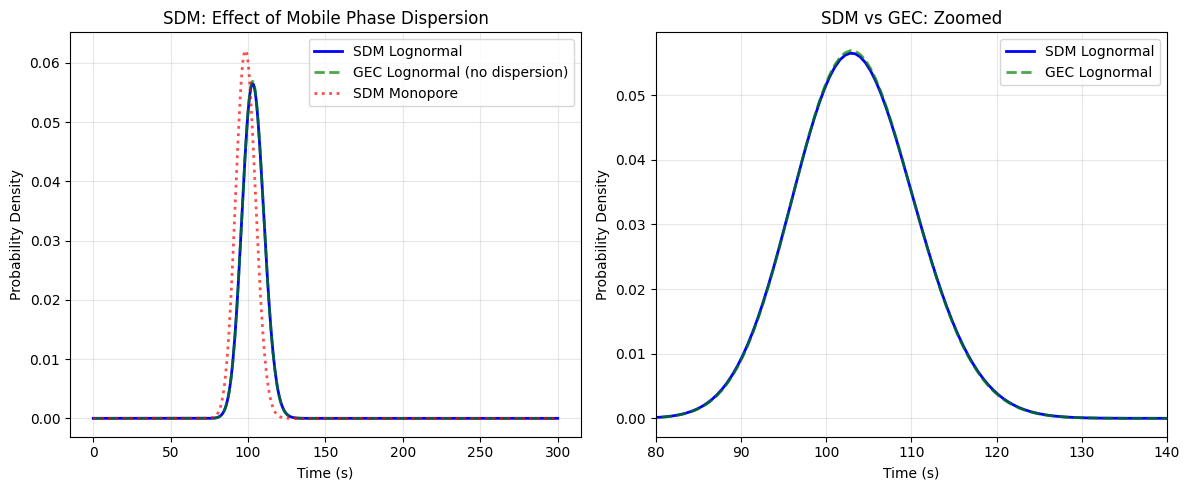

✓ SDM models computed and plotted
  Note: Dispersion (N0=14400.0) causes slight broadening


In [4]:
print("Computing SDM models...")

# SDM Lognormal pore
pdf_sdm_lognormal = sdm_lognormal_pore_pdf(t, scale, N, T, me, mp, mu, sigma, Rg, N0, t0)

# SDM Monopore for comparison
pdf_sdm_mono = sdm_monopore_pdf(t, np_mono, tp_mono, N0, t0)

# GEC Lognormal for comparison (no dispersion)
pdf_gec_lognormal_shifted = gec_lognormal_pore_pdf(t, scale, N, T, me, mp, mu, sigma, Rg, t0)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, pdf_sdm_lognormal, 'b-', linewidth=2, label='SDM Lognormal')
plt.plot(t, pdf_gec_lognormal_shifted, 'g--', linewidth=2, label='GEC Lognormal (no dispersion)', alpha=0.7)
plt.plot(t, pdf_sdm_mono, 'r:', linewidth=2, label='SDM Monopore', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Probability Density')
plt.title('SDM: Effect of Mobile Phase Dispersion')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(t, pdf_sdm_lognormal, 'b-', linewidth=2, label='SDM Lognormal')
plt.plot(t, pdf_gec_lognormal_shifted, 'g--', linewidth=2, label='GEC Lognormal', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Probability Density')
plt.title('SDM vs GEC: Zoomed')
plt.xlim(80, 140)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ SDM models computed and plotted")
print(f"  Note: Dispersion (N0={N0}) causes slight broadening")

## Test 3: SDM Lognormal with Gamma Residence Time

Testing the most comprehensive model with both structural and kinetic heterogeneity.

Computing SDM Gamma models...


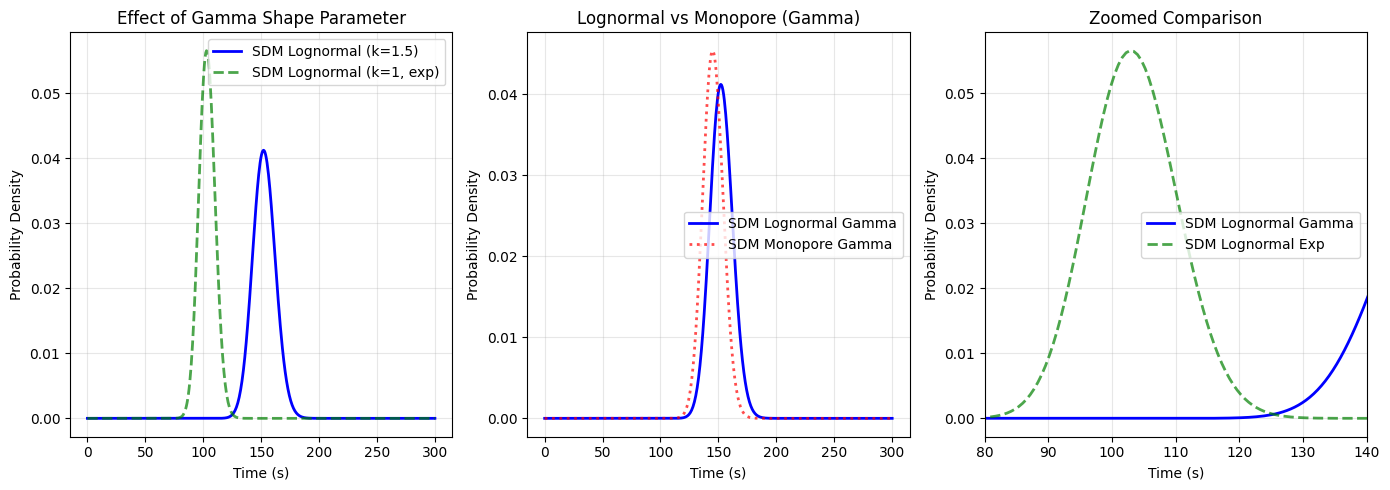

✓ SDM Gamma models computed and plotted
  Gamma shape k=1.5 provides additional flexibility


In [5]:
print("Computing SDM Gamma models...")

# SDM Lognormal with Gamma residence (k=1.5)
pdf_sdm_lognormal_gamma = sdm_lognormal_pore_gamma_pdf(
    t, scale, N, T, k, me, mp, mu, sigma, Rg, N0, t0
)

# SDM Lognormal with exponential (k=1)
pdf_sdm_lognormal_exp = sdm_lognormal_pore_gamma_pdf(
    t, scale, N, T, 1.0, me, mp, mu, sigma, Rg, N0, t0
)

# SDM Monopore with Gamma for comparison
pdf_sdm_mono_gamma = sdm_monopore_gamma_pdf(t, np_mono, k, tp_mono, N0, t0)

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(t, pdf_sdm_lognormal_gamma, 'b-', linewidth=2, label=f'SDM Lognormal (k={k})')
plt.plot(t, pdf_sdm_lognormal_exp, 'g--', linewidth=2, label='SDM Lognormal (k=1, exp)', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Probability Density')
plt.title('Effect of Gamma Shape Parameter')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(t, pdf_sdm_lognormal_gamma, 'b-', linewidth=2, label='SDM Lognormal Gamma')
plt.plot(t, pdf_sdm_mono_gamma, 'r:', linewidth=2, label='SDM Monopore Gamma', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Probability Density')
plt.title('Lognormal vs Monopore (Gamma)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(t, pdf_sdm_lognormal_gamma, 'b-', linewidth=2, label='SDM Lognormal Gamma')
plt.plot(t, pdf_sdm_lognormal_exp, 'g--', linewidth=2, label='SDM Lognormal Exp', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Probability Density')
plt.title('Zoomed Comparison')
plt.xlim(80, 140)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ SDM Gamma models computed and plotted")
print(f"  Gamma shape k={k} provides additional flexibility")

## Test 4: Complete Model Comparison

All implemented models in one plot.

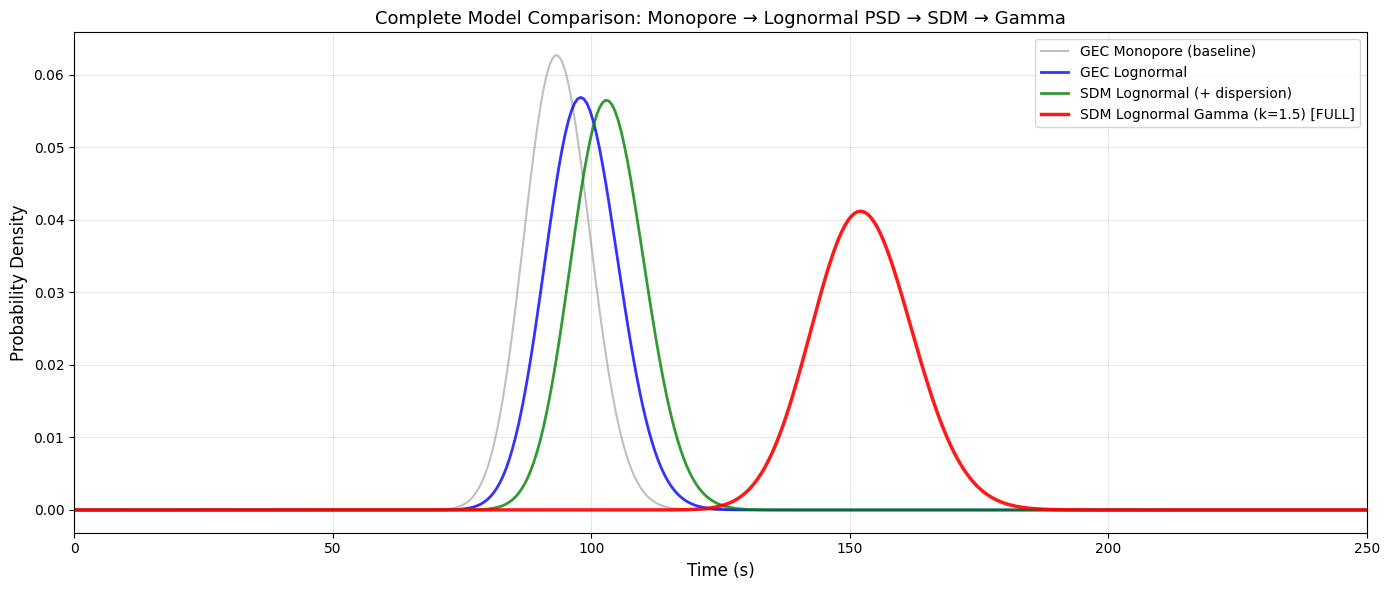


MODEL HIERARCHY SUMMARY
1. GEC Monopore:           Single pore size, exponential residence
2. GEC Lognormal:          + Pore size distribution (Sepsey 2014)
3. SDM Lognormal:          + Mobile phase dispersion
4. SDM Lognormal Gamma:    + Gamma residence time (MOST GENERAL)


In [6]:
plt.figure(figsize=(14, 6))

# Plot all models
plt.plot(t, pdf_gec_mono, 'gray', linewidth=1.5, label='GEC Monopore (baseline)', alpha=0.5)
plt.plot(t, pdf_gec_lognormal, 'b-', linewidth=2, label='GEC Lognormal', alpha=0.8)
plt.plot(t, pdf_sdm_lognormal, 'g-', linewidth=2, label='SDM Lognormal (+ dispersion)', alpha=0.8)
plt.plot(t, pdf_sdm_lognormal_gamma, 'r-', linewidth=2.5, label=f'SDM Lognormal Gamma (k={k}) [FULL]', alpha=0.9)

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('Complete Model Comparison: Monopore → Lognormal PSD → SDM → Gamma', fontsize=13)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(0, 250)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("MODEL HIERARCHY SUMMARY")
print("="*70)
print("1. GEC Monopore:           Single pore size, exponential residence")
print("2. GEC Lognormal:          + Pore size distribution (Sepsey 2014)")
print("3. SDM Lognormal:          + Mobile phase dispersion")
print("4. SDM Lognormal Gamma:    + Gamma residence time (MOST GENERAL)")
print("="*70)

## Test 5: Parameter Sensitivity Analysis

Testing how different parameter values affect the peak shape.

Testing parameter sensitivity...



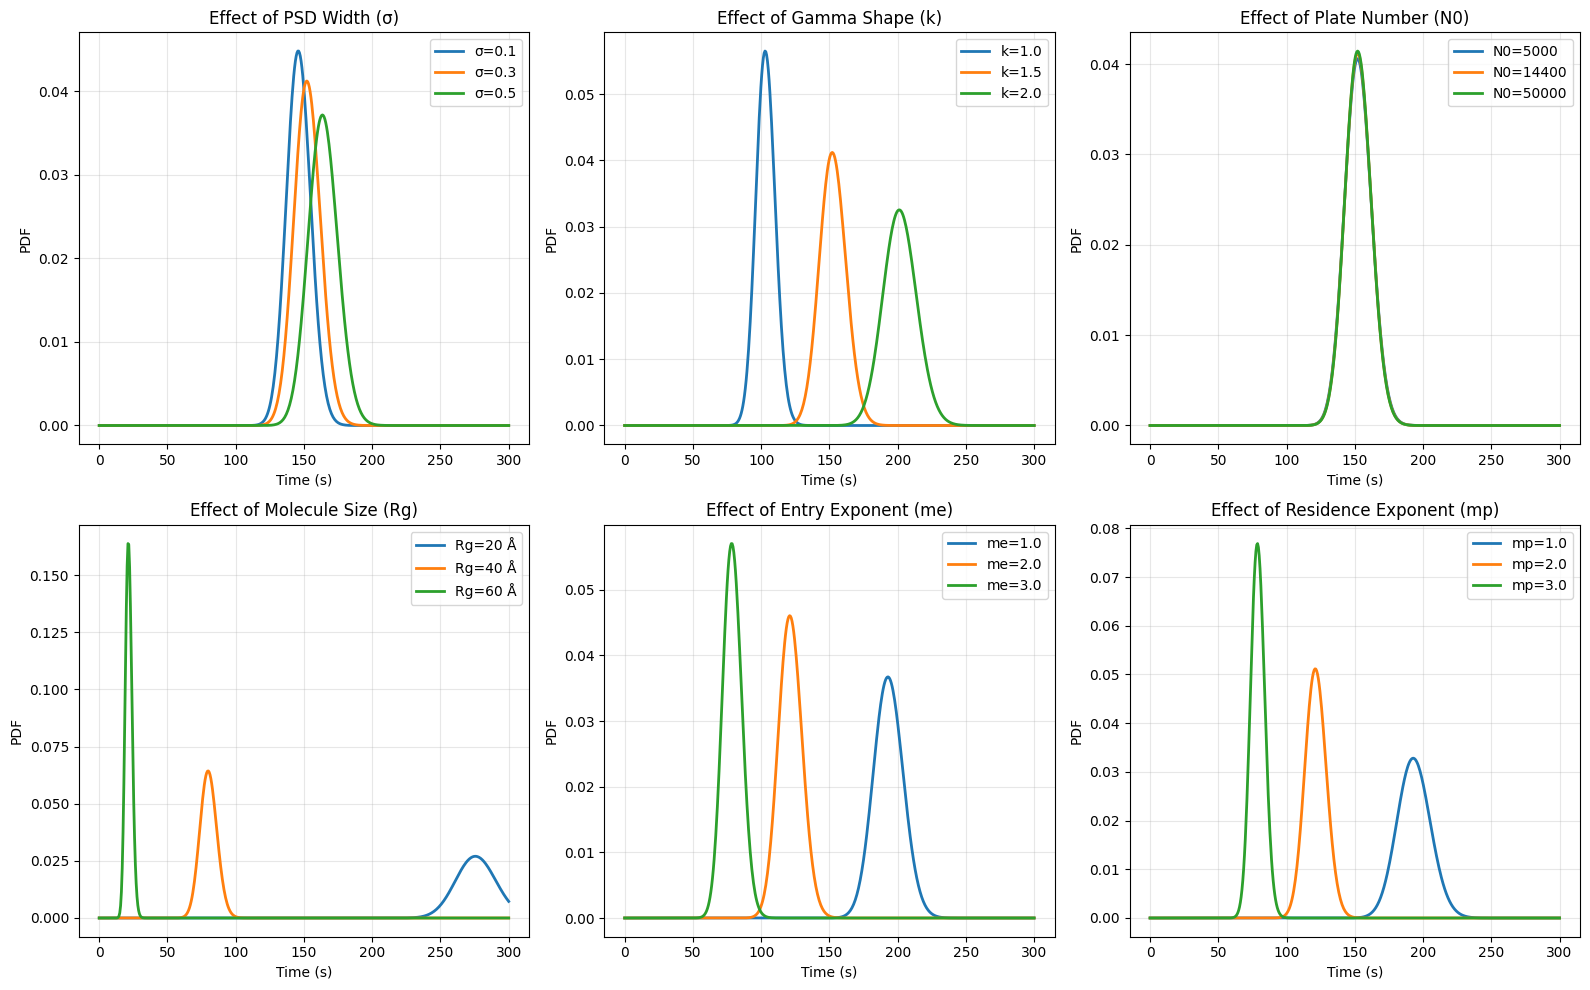

✓ Parameter sensitivity analysis complete


In [7]:
print("Testing parameter sensitivity...\n")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Test 1: Varying sigma (pore size distribution width)
ax = axes[0, 0]
for sig in [0.1, 0.3, 0.5]:
    pdf = sdm_lognormal_pore_gamma_pdf(t, scale, N, T, k, me, mp, mu, sig, Rg, N0, t0)
    ax.plot(t, pdf, linewidth=2, label=f'σ={sig}')
ax.set_title('Effect of PSD Width (σ)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('PDF')
ax.legend()
ax.grid(True, alpha=0.3)

# Test 2: Varying k (Gamma shape)
ax = axes[0, 1]
for k_test in [1.0, 1.5, 2.0]:
    pdf = sdm_lognormal_pore_gamma_pdf(t, scale, N, T, k_test, me, mp, mu, sigma, Rg, N0, t0)
    ax.plot(t, pdf, linewidth=2, label=f'k={k_test}')
ax.set_title('Effect of Gamma Shape (k)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('PDF')
ax.legend()
ax.grid(True, alpha=0.3)

# Test 3: Varying N0 (plate number)
ax = axes[0, 2]
for N0_test in [5000, 14400, 50000]:
    pdf = sdm_lognormal_pore_gamma_pdf(t, scale, N, T, k, me, mp, mu, sigma, Rg, N0_test, t0)
    ax.plot(t, pdf, linewidth=2, label=f'N0={N0_test}')
ax.set_title('Effect of Plate Number (N0)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('PDF')
ax.legend()
ax.grid(True, alpha=0.3)

# Test 4: Varying Rg (molecule size)
ax = axes[1, 0]
for Rg_test in [20, 40, 60]:
    pdf = sdm_lognormal_pore_gamma_pdf(t, scale, N, T, k, me, mp, mu, sigma, Rg_test, N0, t0)
    ax.plot(t, pdf, linewidth=2, label=f'Rg={Rg_test} Å')
ax.set_title('Effect of Molecule Size (Rg)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('PDF')
ax.legend()
ax.grid(True, alpha=0.3)

# Test 5: Varying me (entry exponent)
ax = axes[1, 1]
for me_test in [1.0, 2.0, 3.0]:
    pdf = sdm_lognormal_pore_gamma_pdf(t, scale, N, T, k, me_test, mp, mu, sigma, Rg, N0, t0)
    ax.plot(t, pdf, linewidth=2, label=f'me={me_test}')
ax.set_title('Effect of Entry Exponent (me)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('PDF')
ax.legend()
ax.grid(True, alpha=0.3)

# Test 6: Varying mp (residence exponent)
ax = axes[1, 2]
for mp_test in [1.0, 2.0, 3.0]:
    pdf = sdm_lognormal_pore_gamma_pdf(t, scale, N, T, k, me, mp_test, mu, sigma, Rg, N0, t0)
    ax.plot(t, pdf, linewidth=2, label=f'mp={mp_test}')
ax.set_title('Effect of Residence Exponent (mp)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('PDF')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Parameter sensitivity analysis complete")

## Summary

All lognormal pore distribution models have been tested successfully:

1. ✅ **GEC Lognormal Pore** - Basic model with pore size distribution
2. ✅ **SDM Lognormal Pore** - Added mobile phase dispersion
3. ✅ **SDM Lognormal Pore Gamma** - Added Gamma residence time distribution

The models show expected behavior:
- Lognormal PSD broadens peaks compared to monopore
- Mobile phase dispersion adds additional broadening
- Gamma residence time provides flexibility in tail shape
- All parameters show sensible effects on peak shape

### Key Observations:
- **σ (PSD width)**: Wider distribution → broader, more asymmetric peaks
- **k (Gamma shape)**: Lower k → heavier tails, more dispersed
- **N0 (plate number)**: Higher N0 → sharper peaks (less dispersion)
- **Rg (molecule size)**: Larger molecules → earlier elution (less retention)
- **me, mp (exponents)**: Control size-dependent entry and residence

The implementation is ready for fitting real SEC-SAXS data!